In [1]:
import os
from os import path

import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import spreg
import statsmodels.api as sm
from matplotlib import pyplot as plt
from matplotlib import colors
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from pysal.lib import weights
from pysal.explore import esda
from pysal.viz import splot
from splot.esda import plot_moran
from scipy import stats

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
input_dir = "data/"

# 1. Input data

In [3]:
# get input data
env_data = gpd.read_file(path.join(input_dir,"AGGR_DHS_buffer_4stats.shp"))# get environmental data

dhs_data = pd.read_csv(path.join(input_dir,"DHSdata_aggr2join_buffer.csv"))# get DHS data
dhs_data = dhs_data.iloc[: , 1:]# drop first column (old index)
dhs_data = dhs_data.drop(['geometry'], axis=1)# drop geometry column

data_gdf = pd.merge(dhs_data, env_data, on='v001', how='left')# join datasets
data_gdf = gpd.GeoDataFrame(data_gdf,geometry='geometry')# turn into GDF
data_gdf['geometry'] = data_gdf['geometry'].centroid# turn back to point geometry

data_gdf

,DHSID,DHSCC,DHSYEAR,v001,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,...,rd_len_LI,rd_pc_LI,pc_HiDen,pc_VHden,prop_Prec,pc_PrecAr,pc_VPrcAr,pc_WelIll,pc_VWelIl,geometry
0,CI201200000001,CI,2012.0,1.0,9.0,Sud sans Abidjan,GPS,R,5.973453,-3.198473,...,0.935515,0.01155938331595235,0,0,22.22222222222224,22.22222222222222,0,0,0,POINT (-3.19847 5.97345)
1,CI201200000002,CI,2012.0,2.0,8.0,Ouest,GPS,R,6.462503,-8.211979,...,0.000000,0,0,0,100,100,0,0,0,POINT (-8.21198 6.46250)
2,CI201200000003,CI,2012.0,3.0,8.0,Ouest,GPS,R,7.274597,-8.324563,...,0.414876,0.009099259461077081,None,None,None,None,None,None,None,POINT (-8.32456 7.27460)
3,CI201200000004,CI,2012.0,4.0,6.0,Nord-Est,GPS,R,7.731449,-3.059561,...,0.000000,0,0,0,100,100,0,0,0,POINT (-3.05956 7.73145)
4,CI201200000005,CI,2012.0,5.0,3.0,Centre-Nord,GPS,U,7.713830,-5.040708,...,111.449423,0.5894592012967101,100,0,0,0,0,100,5.555555555555554,POINT (-5.04071 7.71383)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,CI201200000348,CI,2012.0,348.0,4.0,Centre-Ouest,GPS,R,6.361619,-5.715785,...,0.150578,0.004093965954248088,0,0,21.4285714285714,21.42857142857141,0,0,0,POINT (-5.71578 6.36162)
347,CI201200000349,CI,2012.0,349.0,1.0,Centre,GPS,R,6.987534,-5.277727,...,2.964994,0.05858511109025522,0,0,0,0,0,0,0,POINT (-5.27773 6.98753)
348,CI201200000350,CI,2012.0,350.0,2.0,Centre-Est,GPS,U,7.136385,-3.200418,...,43.341645,0.4133437024220832,52.38095238095239,0,19.04761904761904,19.04761904761905,0,34.92063492063492,0,POINT (-3.20042 7.13638)
349,CI201200000351,CI,2012.0,351.0,4.0,Centre-Ouest,GPS,R,6.658221,-6.512773,...,6.170473,0.1045737020213004,0,0,12.50000000000005,12.50000000000004,0,0,0,POINT (-6.51277 6.65822)


## 1.1. Check & clean input data

In [4]:
# Several buffer zones (n=74) don't have any built-up pixel (hence no settlement categorization)
data_gdf[data_gdf.pc_PrecAr.isna()].built_pix.value_counts()

0.0    74
Name: built_pix, dtype: int64

In [5]:
# (!) Several buffer zones (n=10) don't have valid GPS coordinates
data_gdf[data_gdf.LATNUM==0].v001

148    149.0
165    166.0
173    174.0
185    186.0
205    206.0
292    294.0
313    315.0
328    330.0
340    342.0
343    345.0
Name: v001, dtype: float64

In [6]:
# (!) Some buffer zones (n=5) don't have any built-up pixel but are 'urban' according to DHS
data_gdf[((data_gdf.built_pix==0)|(data_gdf.built_pix.isna()))&(data_gdf.URBAN_RURA=='U')][['pc_PrecAr','den_med']]

,pc_PrecAr,den_med
90,None,NaN
207,None,8.539253
227,None,NaN
299,None,NaN
337,None,NaN


#### Remove invalid observations (n=15) : 'urban' buffers with no built-up area (n=5), or invalid GPS coordinates (n=10)

In [7]:
excl_index_lst = data_gdf[(((data_gdf.built_pix==0)|(data_gdf.built_pix.isna()))&(data_gdf.URBAN_RURA=='U'))
                          |(data_gdf['LATNUM']==0)].index.to_list()
data_gdf_check = data_gdf.copy()
data_gdf_check = data_gdf_check[data_gdf_check.index.isin(list(set(data_gdf_check.index.to_list())-set(excl_index_lst)))]

#### Drop observations without any built-up pixel (analysis focuses on urban settlements)

In [8]:
# Drop observations without any built-up pixel
print('dropped obs. without any built-up pixel:',data_gdf_check.shape[0]-data_gdf_check[data_gdf_check['built_pix']>0].shape[0])
data_gdf_check = data_gdf_check[data_gdf_check['built_pix']>0].copy()
print('new dataset shape:',data_gdf_check.shape)

dropped obs. without any built-up pixel: 69
new dataset shape: (267, 188)


#### Keep only most urbanized buffers (prop_190 > series' mean)

In [9]:
# Drop observations with low levels of urbanization
print('dropped obs. with low urb. level:',data_gdf_check.shape[0]-data_gdf_check[data_gdf_check['prop_190']>data_gdf_check['prop_190'].mean()].shape[0])
data_gdf_check = data_gdf_check[data_gdf_check['prop_190']>data_gdf_check['prop_190'].mean()]
print('new dataset shape:',data_gdf_check.shape)
data_gdf_check

dropped obs. with low urb. level: 162
new dataset shape: (105, 188)


,DHSID,DHSCC,DHSYEAR,v001,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,...,rd_len_LI,rd_pc_LI,pc_HiDen,pc_VHden,prop_Prec,pc_PrecAr,pc_VPrcAr,pc_WelIll,pc_VWelIl,geometry
4,CI201200000005,CI,2012.0,5.0,3.0,Centre-Nord,GPS,U,7.713830,-5.040708,...,111.449423,0.5894592012967101,100,0,0,0,0,100,5.555555555555554,POINT (-5.04071 7.71383)
8,CI201200000009,CI,2012.0,9.0,11.0,Ville D'Abidjan,GPS,U,5.358886,-3.987535,...,58.858547,0.3019774937546797,100,0,0,0,0,100,100,POINT (-3.98753 5.35889)
9,CI201200000010,CI,2012.0,10.0,8.0,Ouest,GPS,U,7.410940,-7.555014,...,51.959605,0.4121617839305056,100,0,16.66666666666666,16.66666666666667,0,83.33333333333334,30.70175438596491,POINT (-7.55501 7.41094)
10,CI201200000011,CI,2012.0,11.0,3.0,Centre-Nord,GPS,U,7.714617,-5.011033,...,72.335688,0.4470972555750365,100,0,23.76237623762376,23.76237623762376,0,76.23762376237624,11.88118811881188,POINT (-5.01103 7.71462)
11,CI201200000012,CI,2012.0,12.0,10.0,Sud-Ouest,GPS,U,5.779923,-6.577702,...,27.737310,0.2405644421194763,60.97560975609756,0,30.48780487804878,30.48780487804878,0,30.48780487804878,23.17073170731707,POINT (-6.57770 5.77992)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,CI201200000343,CI,2012.0,343.0,2.0,Centre-Est,GPS,U,6.728393,-3.485607,...,54.343629,0.4433936804230175,74.73684210526316,0,20,20,0,55.78947368421053,0,POINT (-3.48561 6.72839)
342,CI201200000344,CI,2012.0,344.0,11.0,Ville D'Abidjan,GPS,U,5.284774,-3.960389,...,87.033586,0.5001339532833962,99.01960784313727,88.23529411764706,16.66666666666667,16.66666666666667,6.862745098039215,93.13725490196077,71.56862745098039,POINT (-3.96039 5.28477)
345,CI201200000347,CI,2012.0,347.0,3.0,Centre-Nord,GPS,U,7.684719,-5.045481,...,91.943125,0.4893397841519189,100,0,0,0,0,100,43.18181818181818,POINT (-5.04548 7.68472)
348,CI201200000350,CI,2012.0,350.0,2.0,Centre-Est,GPS,U,7.136385,-3.200418,...,43.341645,0.4133437024220832,52.38095238095239,0,19.04761904761904,19.04761904761905,0,34.92063492063492,0,POINT (-3.20042 7.13638)


# 2. Explore correlations & select relevant independent variables

## 2.1 Reformat data & replace nan by 0s
Necessary to replace "nan"s by 0s before running regressions (cells with nan indicate 0 observations for the variable in question)

In [10]:
# Get data
data = data_gdf_check.copy()

# Drop unused columns
drop_list = ['DHSID','DHSCC','DHSCLUST','DHSREGNA','DHSYEAR','DHSREGCO','DHSREGNA',
             'SOURCE','LATNUM','LONGNUM','ALT_GPS','ALT_DEM','DATUM',
             'cU5_0','cU5_2','pop_U5','cU5bis_0','cU5bis_2','pop_U5bis',
             'pp_imp_w','pp_unim_w','pp_imp_s','pp_unim_s','pp_imp_h','pp_unim_h',
             'pp_bas_w','pp_noba_w','pp_bas_s','pp_noba_s','pp_bas_h','pp_noba_h',
             'wcnt_2','wcnt_0','wcnt_1','wcnt_3','wcnt_4','wcnt_5','wpop',
             'wcntBis_2','wcntBis_0','wcntBis_1','wcntBis_3','wcntBis_4','wcntBis_5','wpopBis',
             'den_count','00_14_cnt','90_00_cnt','75_90_cnt','b75_cnt',
             'RdLen_LI1','RdLen_LI2','RdLen_LI3','RdLen_LI4','RdLen_LI5',
             'pc_PrecAr',# drop 'pc_PrecAr' & keep 'prop_Prec' (they are the same)
             'pc_WnoedBis'# drop education level calculated with non-de jure population
             ]
for col in drop_list:
    if col in data.columns.to_list():
        data = data.drop(col,axis='columns')

# Rename cols (first character in var name must be string)
data = data.rename(columns={'prop_Prec':'pc_PrecAr'})

# Add variable: dense precarious areas
data['prop_4342'] = np.nan
data['prop_4342'] = data['prop_19043']+data['prop_19042']
data['pc_DenPrAr'] = np.nan
data['pc_DenPrAr'] = data['prop_4342']/data['prop_190']

# Replace NaNs by 0s
data = data.fillna(0)

# Set non-numeric variable types to 'float' (except for categorical variables)
var_list = list(data.columns.difference(['v001','URBAN_RURA','geometry']))
for v in var_list:
    if str(data[v].dtype) == 'object':
        data[v] = data[v].astype(float)
    else:
        data[v] = data[v]
        
#Check result
data

,v001,URBAN_RURA,wt,dPrevU5,dPrevU5bis,pc_imp_w,pc_bas_w,pc_imp_s,pc_bas_s,pc_imp_h,...,rd_pc_LI,pc_HiDen,pc_VHden,pc_PrecAr,pc_VPrcAr,pc_WelIll,pc_VWelIl,geometry,prop_4342,pc_DenPrAr
4,5.0,U,0.922173,0.210526,0.250000,100.000000,100.000000,67.692308,18.461538,15.625000,...,0.589459,100.000000,0.000000,0.000000,0.000000,100.000000,5.555556,POINT (-5.04071 7.71383),0.000000,0.000000
8,9.0,U,1.012745,0.000000,0.000000,100.000000,100.000000,100.000000,100.000000,82.208589,...,0.301977,100.000000,0.000000,0.000000,0.000000,100.000000,100.000000,POINT (-3.98753 5.35889),0.000000,0.000000
9,10.0,U,0.897664,0.363636,0.363636,100.000000,100.000000,61.728395,8.641975,100.000000,...,0.412162,100.000000,0.000000,16.666667,0.000000,83.333333,30.701754,POINT (-7.55501 7.41094),0.000000,0.000000
10,11.0,U,0.572191,0.125000,0.125000,84.105960,75.496689,84.768212,37.748344,64.197531,...,0.447097,100.000000,0.000000,23.762376,0.000000,76.237624,11.881188,POINT (-5.01103 7.71462),0.000000,0.000000
11,12.0,U,0.635868,0.000000,0.000000,85.263158,74.736842,80.000000,33.684211,53.191489,...,0.240564,60.975610,0.000000,30.487805,0.000000,30.487805,23.170732,POINT (-6.57770 5.77992),0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,343.0,U,0.331017,0.250000,0.235294,100.000000,100.000000,44.859813,10.280374,13.541667,...,0.443394,74.736842,0.000000,20.000000,0.000000,55.789474,0.000000,POINT (-3.48561 6.72839),0.000000,0.000000
342,344.0,U,0.305687,0.250000,0.250000,100.000000,98.347107,100.000000,96.694215,61.983471,...,0.500134,99.019608,88.235294,16.666667,6.862745,93.137255,71.568627,POINT (-3.96039 5.28477),12.977099,0.166667
345,347.0,U,1.107114,0.052632,0.052632,79.365079,79.365079,73.809524,48.412698,29.310345,...,0.489340,100.000000,0.000000,0.000000,0.000000,100.000000,43.181818,POINT (-5.04548 7.68472),0.000000,0.000000
348,350.0,U,0.299906,0.272727,0.230769,83.544304,83.544304,96.202532,11.392405,10.000000,...,0.413344,52.380952,0.000000,19.047619,0.000000,34.920635,0.000000,POINT (-3.20042 7.13638),0.000000,0.000000


## 2.2 Feature selection, step I :  Stepwise selectiob (combine "forward" and "backward" regressions)  
Features are selected based on their p-values after running the forward and backward regressions

In [11]:
# Format data for stepwise selection

# Get data (copy of filtered dataset)
dbf_c = data.copy()

# Indicate dependent variable
dep_var = 'dPrevU5'

# Scale values (min/max) of ind. variables
ind_cols = dbf_c.columns.difference(['URBAN_RURA','v001','wt',
                                     'dPrevU5bis',
                                     'geometry']
                                    ).to_list()
for var in ind_cols:
    dbf_c[var] = ((dbf_c[var] - dbf_c[var].min())/
                  (dbf_c[var].max() - dbf_c[var].min()))

# Check that all data types are numeric
lst = []
for col in dbf_c[ind_cols].columns.to_list():
    lst = lst+[str(dbf_c[col].dtype)]
# Function to get unique values
def unique(list1):
    unique_list = []
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print(x)
# Show list of unique data types (all must be numeric)
print("the data type(s) is/are:")
unique(lst)

# Check for NaNs (list columns with NaNs eventually generated by min/max scaler):
lst = []
for var in dbf_c[ind_cols].columns.to_list():
    if dbf_c[dbf_c[var].isna()].shape[0]>0:
        lst = lst+[var]
if len(lst)>0:
    print('exluding following columns containing nan values:',lst)
    for var in lst:
        sel_cols = dbf_c.columns.difference(lst)
        dbf_c = dbf_c[sel_cols]
else:
    print('all columns OK (no cells with nan values)')

# Check min/max values:
print('min. values for indep. variables:',dbf_c[list(set(ind_cols)-set(lst))].min().unique())
print('max. values for indep. variables:',dbf_c[list(set(ind_cols)-set(lst))].max().unique())

# Update ind_cols
# 1. drop dependent & control variables:
exclude_lst = ['dPrevU5',# exlude dep. variable from stepwise process
               'dPrevU5bis',# exlude dep. variable (bis) from stepwise process
               'pc_bas_w','pc_bas_s',# exlude control variables from stepwise process (WASH + education)
               'pc_imp_w','pc_imp_s','pc_imp_h',
               'pc_Wnoed'
              ]
# 2. drop obsolete variables (focus on ESA CCI LC):
exclude_lst2 = ['pc_00_14','pc_90_00','pc_75_90','pc_b75',# exclude GHS variables
               ]
# 3. drop morphological indicators that are hardly interpretable (subtypes of 'precarious' areas)
exclude_lst3 = []
string_lst = ['edge_1901','frac_1901',
              'edge_1902','frac_1902',
              'edge_1903','frac_1903',
              'edge_1904','frac_1904'
             ]
for s in string_lst:
    exclude_lst3 = exclude_lst3+list(filter(lambda x: s in x, dbf_c.columns.to_list()))
# 3. update list (dropping NaNs eventually generated by min/max scaler)
ind_cols = sorted(list(set(ind_cols)-set(lst+exclude_lst+exclude_lst2+exclude_lst3)))
print('columns dropped from ind_cols :',lst+exclude_lst+exclude_lst2+exclude_lst3)

# Check data
dbf_c

the data type(s) is/are:
float64
exluding following columns containing nan values: ['edge_110', 'edge_160', 'edge_180', 'edge_19011', 'edge_19021', 'edge_60', 'frac_110', 'frac_160', 'frac_180', 'frac_19011', 'frac_19021', 'frac_60', 'prop_110', 'prop_160', 'prop_180', 'prop_19011', 'prop_19021', 'prop_60']
min. values for indep. variables: [0.]
max. values for indep. variables: [1.]
columns dropped from ind_cols : ['edge_110', 'edge_160', 'edge_180', 'edge_19011', 'edge_19021', 'edge_60', 'frac_110', 'frac_160', 'frac_180', 'frac_19011', 'frac_19021', 'frac_60', 'prop_110', 'prop_160', 'prop_180', 'prop_19011', 'prop_19021', 'prop_60', 'dPrevU5', 'dPrevU5bis', 'pc_bas_w', 'pc_bas_s', 'pc_imp_w', 'pc_imp_s', 'pc_imp_h', 'pc_Wnoed', 'pc_00_14', 'pc_90_00', 'pc_75_90', 'pc_b75', 'edge_19012', 'edge_19013', 'edge_19014', 'frac_19012', 'frac_19013', 'frac_19014', 'edge_19022', 'edge_19023', 'edge_19024', 'frac_19022', 'frac_19023', 'frac_19024', 'edge_19031', 'edge_19032', 'edge_19033', 'e

,RdLenTot,URBAN_RURA,ac_ppt16,built_pix,dPrevU5,dPrevU5bis,den_med,edge_1,edge_10,edge_100,...,prop_4342,prop_50,prop_62,rdTt_BtHa,rd_len_LI,rd_pc_LI,std_ppt16,std_tmx16,v001,wt
4,0.726337,U,0.249834,0.93,0.385965,0.250000,0.179513,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.362281,0.828099,1.000000,0.081549,0.641519,5.0,0.922173
8,0.754417,U,0.922412,0.97,0.000000,0.000000,0.127529,0.000000,0.076741,0.0,...,0.000000,0.0,0.0,0.361640,0.393219,0.320465,0.566372,0.352434,9.0,1.012745
9,0.423385,U,0.275225,0.81,0.666667,0.363636,0.099213,0.579649,0.066469,0.0,...,0.000000,0.0,0.0,0.159849,0.336171,0.580913,0.186488,0.447171,10.0,0.897664
10,0.595159,U,0.243304,0.68,0.229167,0.125000,0.077544,0.515625,0.329748,0.0,...,0.000000,0.0,0.0,0.414241,0.504663,0.663492,0.078585,0.625185,11.0,0.572191
11,0.371622,U,0.000000,0.49,0.000000,0.000000,0.019944,0.654447,0.263799,0.0,...,0.000000,0.0,0.0,0.313841,0.135875,0.175300,0.000000,0.198452,12.0,0.635868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,0.406541,U,0.507757,0.62,0.458333,0.235294,0.063016,0.620082,0.399524,0.0,...,0.000000,0.0,0.0,0.254364,0.355885,0.654737,0.080602,0.511101,343.0,0.331017
342,0.653970,U,0.931351,0.69,0.458333,0.250000,0.871233,0.445684,0.000000,0.0,...,0.236832,0.0,0.0,0.467684,0.626202,0.788857,0.621533,0.381188,344.0,0.305687
345,0.720671,U,0.255635,0.99,0.096491,0.052632,0.126425,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.322722,0.666799,0.763343,0.081020,0.641773,347.0,1.107114
348,0.321400,U,0.453693,0.30,0.500000,0.230769,0.009784,0.515625,0.501218,0.0,...,0.000000,0.0,0.0,0.446298,0.264909,0.583707,0.089395,0.619384,350.0,0.299906


In [12]:
# Run stepwise selection
# source: https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/

def stepwise_selection(data, target, SL_in=0.1, SL_out=0.1):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break
        else:
            break
    return best_features

best_features = stepwise_selection(dbf_c[ind_cols], dbf_c[dep_var], SL_in=0.1, SL_out=0.1)#(select if P<0.1)
best_features

['prop_4342', 'prop_19013', 'frac_40', 'edge_190']

#### Check distribution of features selected by stepwise method

prop_4342 ,non-adjusted


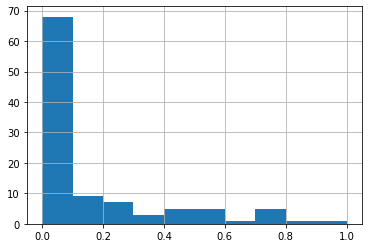

prop_19013 ,non-adjusted


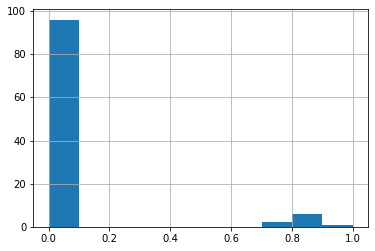

frac_40 ,non-adjusted


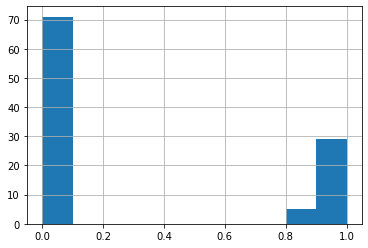

edge_190 ,non-adjusted


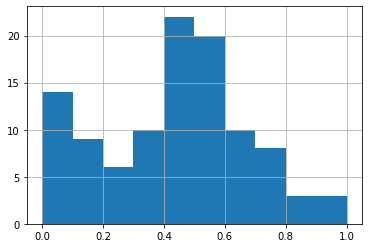

In [13]:
for var in best_features:
    print(var,',non-adjusted')
    dbf_c[var].hist()
    plt.show()

## 2.3 Feature selection, step II : Spearman correlations
Check all significant correlations (P<0.1)  
Verify consistency of stepwise seletion by analyzing individual Spearman correlation coefficients  

In [14]:
# Calculate spearman correlations & p-values

# NOTE: Many variables show ZERO-CLUSTERS (many obs. where ind. var. == 0)

# Create dataframe
spear_corr_df = pd.DataFrame()

# Run Spearman correlations for each variable
for var in dbf_c[ind_cols+exclude_lst].columns.difference(['dPrevU5','dPrevU5bis']).to_list():
    spear_r = stats.spearmanr(dbf_c[dep_var],dbf_c[var])[0]
    spear_r_p = stats.spearmanr(dbf_c[dep_var],dbf_c[var])[1]
    obs_var = dbf_c[dbf_c[var]>0].shape[0]
    df = pd.DataFrame([[spear_r, spear_r_p, obs_var]])
    df.index = [var]
    spear_corr_df = spear_corr_df.append(df)
    
# Select significant variables :

# P-value threshold: < 0.1
p_val = 0.1

# List of significant environmental variables, according to criteria above:
spear_corr_df.columns = ["SpCoPrv12","Pval","N_obs>0"]
spear_corr_df_sel_bis = spear_corr_df[(spear_corr_df['Pval']<p_val)]

print("number of sign. variables : ",
      spear_corr_df_sel_bis.shape[0],
      "(out of ",
      spear_corr_df.shape[0],")")

print("p-val. threshold:",p_val)

spear_corr_df_sel_bis

number of sign. variables :  10 (out of  83 )
p-val. threshold: 0.1


,SpCoPrv12,Pval,N_obs>0
edge_1,0.216220,0.026736,89
frac_40,-0.199276,0.041548,34
mn_tmax16,-0.161767,0.099218,104
pc_DenPrAr,0.238022,0.014483,42
pc_PrecAr,0.203502,0.037328,89
pc_VPrcAr,0.186248,0.057130,20
prop_1,0.250857,0.009847,89
prop_19042,0.214156,0.028257,19
prop_19043,0.230395,0.018055,42
prop_4342,0.240703,0.013382,42


In [15]:
# Check correlations for variables selected from stepwise selection

spear_corr_stepwise_sel = pd.DataFrame()

for var in best_features:
    spear_r = stats.spearmanr(dbf_c[dep_var],dbf_c[var])[0]
    spear_r_p = stats.spearmanr(dbf_c[dep_var],dbf_c[var])[1]
    obs_var = dbf_c[dbf_c[var]>0].shape[0]
    df = pd.DataFrame([[spear_r, spear_r_p, obs_var]])
    df.index = [var]
    spear_corr_stepwise_sel = spear_corr_stepwise_sel.append(df)
    
spear_corr_stepwise_sel.columns = ["SpCoPrv12","Pval","N_obs>0"]

spear_corr_stepwise_sel

,SpCoPrv12,Pval,N_obs>0
prop_4342,0.240703,0.013382,42
prop_19013,-0.093338,0.343615,9
frac_40,-0.199276,0.041548,34
edge_190,-0.002061,0.983356,101


### 2.3.1 Results of feature selection process

Selection based both on: (1) stepwise regression and (2) Spearman correlation filter >> Selected features: 'prop_4342' and 'frac_40'

#### Observations on the selection process:
Two variables selected through the stepwise regression actually show very poor Spearman correlation coefficients (Rho < 0.1 and P values >0.2), and were therefore exluded. Based on the Spearman correlations filter done afterwards, the retained variables are: 'prop_4342' and 'frac_40'. The latter, however, shows a very odd distribution, with values clustered around the extremes (0.0 and 0.9-1.0, see distplot above), and was therefore excluded.  
Again, in the general Sperman correlations table (with all variables having P<0.1), we can identify a global trend where areas with high-density/low-illumination (classes '19043','19042', 'pc_PrecAr' or 'prop_1') are all positively correlated to diarrhoea.  

#### Urban areas
Again, the overall extent and morphology of 'urban' areas (class '190') per se does not seem to affect diarrhoea. However, the quality of urbanization (% of built up areas considered precarious) does. 

# 3. Run multiple regression models

## 3.1 Selected features for regression
We use the same control variables than in the analysis with the full dataset + selected independent variable ('prop_4342')

In [16]:
# Selected independent + control variables
reg_var_list = ['pc_bas_w', 'pc_bas_s', 'pc_Wnoed', 'prop_4342']

print('selected features (control + independent variables):')
print(reg_var_list)

selected features (control + independent variables):
['pc_bas_w', 'pc_bas_s', 'pc_Wnoed', 'prop_4342']


## 3.2 Regression model 1 : unweighted OLS

### 3.2.1 Run OLS regression

In [17]:
# OLS regression with pysal's spreg

# see: https://pysal.org/spreg/generated/spreg.OLS.html#spreg.OLS
# >> include spatial diagnostics for autocorrelation (moran + spat_diag)
# >> these diagnostics indicate whether spatial regression is needed

# set regression inputs
y_var = dbf_c[dep_var].values
x_vars = dbf_c[reg_var_list].values
weight = weights.KNN.from_dataframe(dbf_c,k=8)# k: 8 nearest neighbours

# Run OLS regression
mols = spreg.OLS(y_var,x_vars,weight,
                 name_x=reg_var_list,
                 spat_diag=True)

# See results
print(mols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         105
Mean dependent var  :      0.3304                Number of Variables   :           5
S.D. dependent var  :      0.2340                Degrees of Freedom    :         100
R-squared           :      0.1412
Adjusted R-squared  :      0.1068
Sum squared residual:       4.890                F-statistic           :      4.1093
Sigma-square        :       0.049                Prob(F-statistic)     :    0.003996
S.E. of regression  :       0.221                Log likelihood        :      12.019
Sigma-square ML     :       0.047                Akaike info criterion :     -14.037
S.E of regression ML:      0.2158                Schwarz criterion     :      -0.767

-----------------------------------------------------------------------------

#### Additional test for spatial autocorrelation of dependent variable : global Moran's I
adapted from: https://pysal.org/libpysal/generate/libpysal.weights.KNN.html#libpysal.weights.KNN.from_dataframe

Moran's I for dPrevU5 :  0.03294453069141198 (P= 0.144 )
Expected Moran's I (under normality assumption): -0.009615384615384616
>> global spatial autocorrelation NOT significantly strong


(<Figure size 720x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Reference Distribution'}, xlabel='Moran I: 0.03', ylabel='Density'>,
        <AxesSubplot:title={'center':'Moran Scatterplot (0.03)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

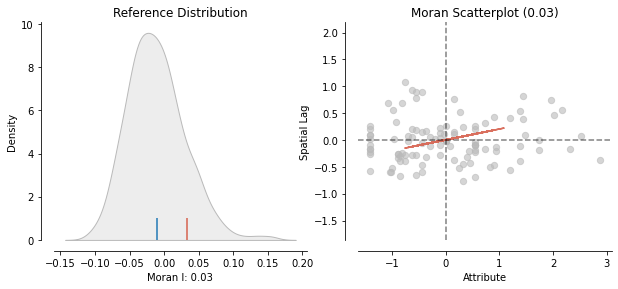

In [18]:
# dummy dataframe
db = dbf_c.copy()

# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(db, k=8)

# Calculate spatial lag: mean 'Y' values of neighbouring cells, at each 'i' location
# Row-standardization (for mean 'Y' values)
w.transform = 'R'
# Spatial lag
db['dPrevRt12_lag'] = weights.spatial_lag.lag_spatial(w, db[dep_var])

# Standardize ind. variable
db['dPrevRt12_std'] = ((db[dep_var] - db[dep_var].mean())/
                       db[dep_var].std())
db['dPrevRt12_lag_std'] = ( db['dPrevRt12_lag'] - db['dPrevRt12_lag'].mean() )\
                    / db['dPrevRt12_lag'].std()

# Moran's I:
v = dep_var
mi = esda.Moran(db[v], w)
print("Moran's I for "+v+" : ",mi.I,"(P=",mi.p_sim,")")
print("Expected Moran's I (under normality assumption):",mi.EI)
if (np.abs(mi.I) > np.abs(mi.EI))&(mi.p_sim<0.05):
    print(">> significant global spatial autocorrelation detected")
else:
    print(">> global spatial autocorrelation NOT significantly strong")

# Moran's plot (standardized values):
plot_moran(mi)
# Plot - left panel:
# We can see in gray the empirical distribution generated from simulating 999 random maps
# with the values of dep. variable and then calculating Moran’s I for each of those maps
# simulated Moran's I is shown in blue; observed Moran's I in red
# Plot - right panel:
# local mean 'Y' (std. spatial lag) VS. observed 'Y' values (std. 'Y') at each 'i' location

### 3.2.2 Check multicollinearity (VIF)

In [19]:
# Check variance inflation factor (VIF) for all features
pd.DataFrame(spreg.vif(mols),index=["constant"]+reg_var_list,columns=["VIF"])

,VIF
constant,None
pc_bas_w,"(1.1718412304090324, 0.8533579243076717)"
pc_bas_s,"(1.7685204330267166, 0.5654444140566474)"
pc_Wnoed,"(1.8101514135542829, 0.5524399740883952)"
prop_4342,"(1.02883537971602, 0.9719727953718125)"


## 3.3 Regression model 2 : OLS with non-spatial weights (cluster weights given by DHS)

In [20]:
# Weighted Least Squares
Y = dbf_c[dep_var].values
X = dbf_c[reg_var_list]
print("x_vars:",reg_var_list)
X = sm.add_constant(X)
wls_model = sm.WLS(Y,X, weights=list(dbf_c.wt))
results = wls_model.fit()
print(results.summary())

# Conduct the Breusch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
test_result = sm.stats.diagnostic.het_breuschpagan(results.resid, results.model.exog)
pd.DataFrame(test_result,index=names,columns=["Breusch-Pagan test (heteroscedasticity)"])

x_vars: ['pc_bas_w', 'pc_bas_s', 'pc_Wnoed', 'prop_4342']
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.196
Model:                            WLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     6.095
Date:                Tue, 14 Jun 2022   Prob (F-statistic):           0.000198
Time:                        22:04:23   Log-Likelihood:                -6.7806
No. Observations:                 105   AIC:                             23.56
Df Residuals:                     100   BIC:                             36.83
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

,Breusch-Pagan test (heteroscedasticity)
Lagrange multiplier statistic,7.100578
p-value,0.130668
f-value,1.813233
f p-value,0.132171


## 3.4 Regression models 3 & 4 : spatial regressions with pysal (spreg)

### 3.4.1 Set weight matrix

#### Note on bandwidth type:  
in this case, given the large distances between points, adaptive bandwidth (KNN) is best option to avoid 'islands' (obs. without neighbours) in spatial regression.  

#### Note on bandwidth value:  
The bandwidth value was set manually, to reasonable number of neighbours: n=8, considering the 8 possible directions (up,down,left,right+diagonals)

In [21]:
bandwidth = 8
weight = weights.KNN.from_dataframe(dbf_c,k=bandwidth)
print("weight:",weight)
print("bandwidth:",bandwidth)
print("reg_var_list:")
print(reg_var_list)

weight: <libpysal.weights.distance.KNN object at 0x7f8e38ebf670>
bandwidth: 8
reg_var_list:
['pc_bas_w', 'pc_bas_s', 'pc_Wnoed', 'prop_4342']


#### Run spatial regressions

In [22]:
# set regression inputs
y_var = dbf_c['dPrevU5'].values
x_vars = dbf_c[reg_var_list].values
var_names = ['%basic wat.'
             ,'%basic san.'
             ,'%women no edu.'
             ,'prop. den. pr. areas'
            ]

if len(var_names)==len(reg_var_list):
    print('length of var_names OK!')
else:
    print('ERROR: check length of "var_names"')

length of var_names OK!


In [23]:
# calculate ML Lag
mlag = spreg.ML_Lag(y_var,x_vars,
                    weight,
                    #method = "ORD",
                    name_x=var_names)

print(mlag.summary)

# Test normality and variance of residuals
pd.DataFrame([list(spreg.jarque_bera(mlag).values())[1:],list(spreg.breusch_pagan(mlag).values())[1:]],
             index=["Jarque-Bera test (normality of residuals)", "Breusch-Pagan test (heteroscedasticity)"],
             columns=["test result","p-value"]
            )

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         105
Mean dependent var  :      0.3304                Number of Variables   :           6
S.D. dependent var  :      0.2340                Degrees of Freedom    :          99
Pseudo R-squared    :      0.1413
Spatial Pseudo R-squared:  0.1418
Sigma-square ML     :       0.047                Log likelihood        :      12.026
S.E of regression   :       0.216                Akaike info criterion :     -12.052
                                                 Schwarz criterion     :       3.872

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

,test result,p-value
Jarque-Bera test (normality of residuals),4.363986,0.112816
Breusch-Pagan test (heteroscedasticity),4.391016,0.355666


In [24]:
# calculate spatial reg. ML Error
mspe = spreg.ML_Error(y_var,x_vars,
                      weight,
                      #method = "ORD",
                      name_x=var_names)

print(mspe.summary)

# Test normality and variance of residuals
pd.DataFrame([list(spreg.jarque_bera(mspe).values())[1:],list(spreg.breusch_pagan(mspe).values())[1:]],
             index=["Jarque-Bera test (normality of residuals)", "Breusch-Pagan test (heteroscedasticity)"],
             columns=["test result","p-value"]
            )

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         105
Mean dependent var  :      0.3304                Number of Variables   :           5
S.D. dependent var  :      0.2340                Degrees of Freedom    :         100
Pseudo R-squared    :      0.1411
Sigma-square ML     :       0.047                Log likelihood        :      12.043
S.E of regression   :       0.216                Akaike info criterion :     -14.086
                                                 Schwarz criterion     :      -0.816

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

,test result,p-value
Jarque-Bera test (normality of residuals),4.285312,0.117343
Breusch-Pagan test (heteroscedasticity),4.423565,0.351707
